# CAPM Modelling

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from pandas_datareader import data as wb
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

### Beta Calculation

In [2]:
# pull AAPL & SPY ETF (S&P 500) data from Yahoo Finance
# for our beta calculations Yahoo Finance uses 5-yr monthly averages, so we use the following for closest results
start_date = (datetime.datetime.now()-datetime.timedelta(days=5*365)).strftime("%Y-%m-%d") 
aapl = wb.DataReader('AAPL', data_source = 'yahoo', start = start_date)
spy_etf = wb.DataReader('SPY', data_source = 'yahoo', start = start_date)
# converting to the monthly mean values, rather than the daily values given by the raw data
aapl_monthly = aapl.resample(rule='BM').mean()
spy_monthly = spy_etf.resample(rule='BM').mean()
# combining adjusted closing values in a single dataframe
data = pd.concat([aapl_monthly['Adj Close'], spy_monthly['Adj Close']], axis = 1)
data.columns = ['AAPL', 'SPY']
data.head()

,AAPL,SPY
Date,,
2016-10-31,27.232075,195.114575
2016-11-30,25.946600,197.831992
2016-12-30,26.944800,205.682459
2017-01-31,28.178333,208.551625
2017-02-28,31.606276,213.886799


In [3]:
# calculating covariance between MSFT & SPY
sec_returns = np.log(data/data.shift(1)) # logarithmic returns
cov = sec_returns.cov() * 12 # ~ number of trading months in year
cov_with_market = cov.iloc[0,1] # storing covariance of AAPL with market
market_var = sec_returns['SPY'].var() * 12 # calculating variance of market through S&P 500

# calculating beta, the stock's risk measure with relation to the market
# b < 1 - Defensive stock
# b = 1 - Same performance as market
# b > 1 - Riskier than market
def calc_beta(cov_with_market, market_var):
    beta = cov_with_market / market_var
    return beta
# AAPL beta calculation
AAPL_beta = calc_beta(cov_with_market, market_var)
print("AAPL Beta: " + str(AAPL_beta))

AAPL Beta: 1.2814756705516965


### Sharpe Ratio Calculation

In [4]:
# now use Sharpe Ratio formula to create metric gauging risk of product
# we can use this to compare stocks with each other in a portfolio
# generally, values greater than 1 are considered acceptable investments

# for AAPL assume a risk-free rate of 2.5% and a risk premium of 5%
AAPL_er = 0.025 + AAPL_beta * 0.05
print("Expected return of AAPL: " + str(AAPL_er))

Expected return of AAPL: 0.08907378352758483


In [5]:
# Sharpe Ratio = (Expected Returns - Risk-Free Returns) / Portfolio Standard Deviation
AAPL_sharpe = (AAPL_er - 0.025) / (sec_returns['AAPL'].std())
AAPL_sharpe # this returns a value slightly less than one, suggesting that AAPL right now isn't a great investment
# regardless, for the purposes of this demo we move on to calculate alpha

0.9130626119028852

### Alpha Calculation

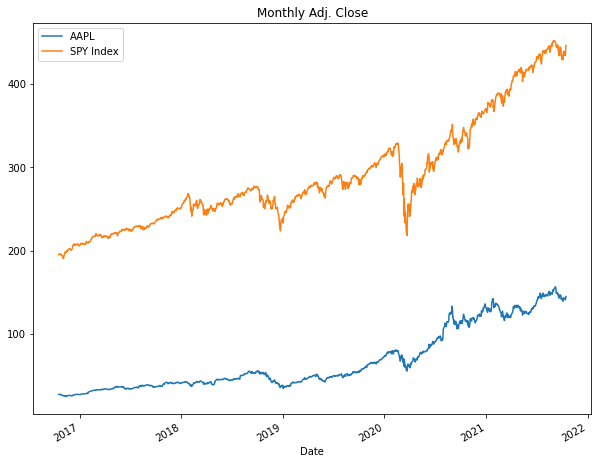

In [6]:
# calculate alpha, determines how much compensation we get without bearing extra risk
# measure of fund performance, high alpha means outperforming market
# because alpha is primarily derived through active trading, we choose to return to daily, instead of monthly, returns

# first plot daily closes of AAPL against the SPY to guage how their behaviors, in relation to each other
aapl['Adj Close'].plot(label='AAPL', title = 'Monthly Adj. Close', figsize=(10,8))
spy_etf['Adj Close'].plot(label='SPY Index')
plt.legend() # see very similar behaviors. move to calculate cumulative returns of each

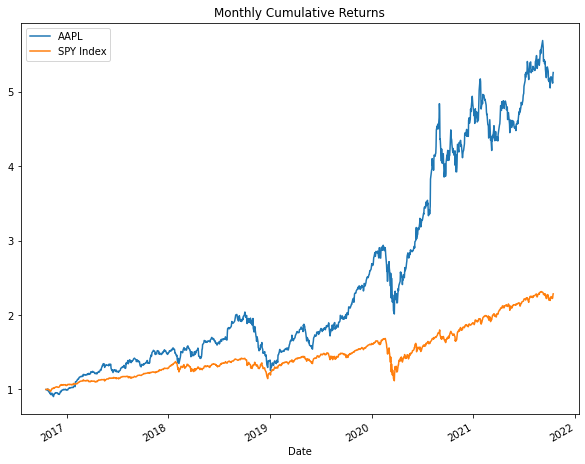

In [7]:
# now calculate and plot the cumulative returns of AAPL with respect to the SPY ETF
aapl['Cumulative'] = aapl['Adj Close']/aapl['Adj Close'].iloc[0]
spy_etf['Cumulative'] = spy_etf['Adj Close']/spy_etf['Adj Close'].iloc[0]

aapl['Cumulative'].plot(label='AAPL', title = 'Monthly Cumulative Returns', figsize=(10,8))
spy_etf['Cumulative'].plot(label='SPY Index')
plt.legend() # see that investing strictly in appl has a greater rate of return than investing in the SPY ETF over 5 years

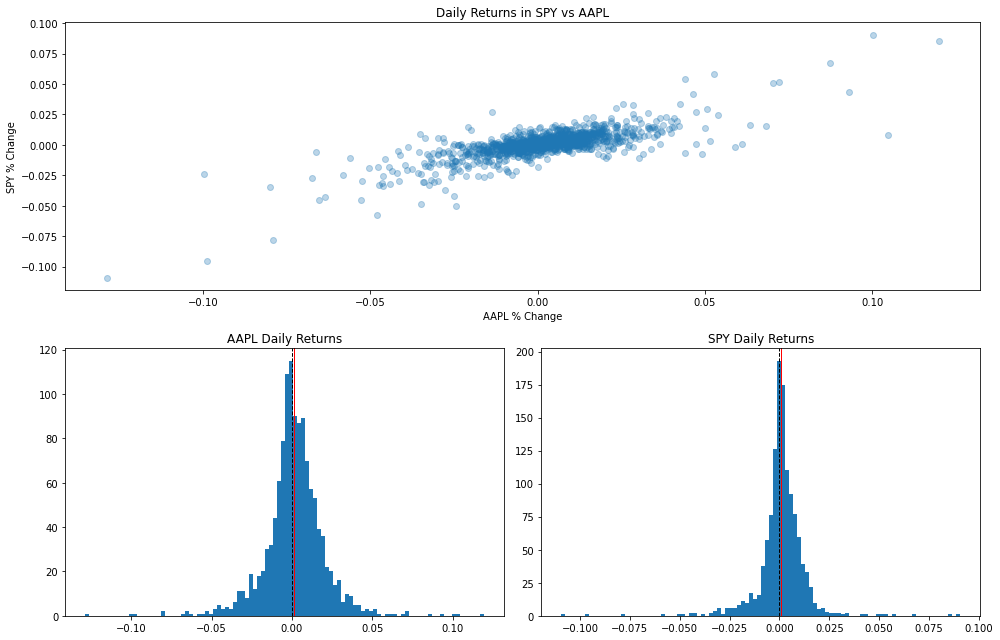

In [8]:
# now calculating percentage daily returns of either possible investment
aapl['Daily Return'] = aapl['Adj Close'].pct_change(1) # percent change in stock value per (1) day
spy_etf['Daily Return'] = spy_etf['Adj Close'].pct_change(1)

# generating figure for relational plots
fig = plt.figure(tight_layout=True, figsize = (14,9))
gs = gridspec.GridSpec(2,2)

# creating scatterplot to show potential correlation
ax = fig.add_subplot(gs[0,:])
ax.scatter(aapl['Daily Return'], spy_etf['Daily Return'], alpha=0.3) 
ax.set_xlabel('AAPL % Change')
ax.set_ylabel('SPY % Change')
ax.set_title('Daily Returns in SPY vs AAPL')

# creating histograms of possible percentage daily returns
ax = fig.add_subplot(gs[1,0])
ax.hist(aapl['Daily Return'], bins=100)
ax.axvline(0, linestyle='dashed', color = 'black', linewidth = 1)
ax.axvline(aapl['Daily Return'].mean(), linestyle='solid', color = 'red', linewidth = 1)
ax.set_title('AAPL Daily Returns')

ax = fig.add_subplot(gs[1,1])
ax.hist(spy_etf['Daily Return'], bins=100)
ax.axvline(0, linestyle='dashed', color = 'black', linewidth = 1)
ax.axvline(spy_etf['Daily Return'].mean(), linestyle='solid', color = 'red', linewidth = 1)
ax.set_title('SPY Daily Returns')

fig.align_labels()
plt.show() 

# scatter plot shows some positive correlation
# histograms show similar behaviors, with average daily returns slightly above zero

In [9]:
# now use linregress method of the stats module to calculate beta, alpha, correlation coefficient,  

beta, alpha, r_value, p_value, std_err = stats.linregress(aapl['Daily Return'].iloc[1:],spy_etf['Daily Return'].iloc[1:])
print("Beta: " + str(beta)) # slope of regression, or beta
print("Alpha: " + str(alpha)) # intercept of our regression, or alpha 
print("r_value: " + str(r_value)) # correlation coefficient, or our sharpe ratio

# We see that this method of calculating beta for daily returns differs wildly from the monthly five-year averages, 
# which are used by Yahoo. We also see a very small alpha close to zero, which show positive (but minimal) returns, 
# and a Sharpe Ratio much closer to those we see on other online resources.

Beta: 0.4730133284883151
Alpha: 1.6936300364904337e-05
r_value: 0.7627595381546339
